# ASR Tutorial Week 1: FSTs and language as graphs
This week our goal is to understand and get some practice with representing language as a graph. We'll be using the `pynini` library to create and interact with Finite State Transducers (FSTs), a graph model frequently used for natural language.

In this exercise, we'll practice using FSTs to map between words and phonemes. For ease of typing phonemes are represented using [Arpabet](https://en.wikipedia.org/wiki/ARPABET) rather than IPA.

In [221]:
import pynini
import graphviz
from typing import *
import numpy as np

## Section 1: Finite State Acceptors
First let's get some basics on how FSTs work. First we'll discuss a special type of FST, a Finite State *Acceptor* (FSA). FSAs are a graph over a certain *language*, where a path on the graph corresponds to a "word" in the given language. Each *arc* on the graph corresponds to a given letter on the language's alphabet.

For example, let's make a graph over the single word "cat".

To do this we first need to create a `SymbolTable`. Since the FST stores each letter as an integer, we need to tell the FST how those integers are mapped to letters in order to visualize the FST with language instead of numbers. To start we'll just map letters to their ASCII code value. We use the `chr` function to convert and integer to it's ASCII character and the `ord` function to convert a character to its ASCII code value.

In [222]:
ascii_table = pynini.SymbolTable()
ascii_table.add_symbol('<eps>')
for i in range(1, 123):
    ascii_table.add_symbol(chr(i))

Let's also write a function to visualize our FSTs (if you put an FST as the last line of code in a cell, it should render automatically, but I find that sometimes the rendering bugs out and messes up the symbols for the FST, whereas this function should be more reliable).

In [223]:
def print_fst(f):
    tmp_path = 'tmp.dot'
    f.draw(tmp_path, portrait=True)
    with open(tmp_path) as file:
        return graphviz.Source(file.read())

Now we can create the FSA (note that, since FSA's are a type of FST, we call `pynini.Fst()` to construct it). To make use of our symbol table, we call `Fst.set_input/output_symbols(ascii_table)`.

In [224]:
f = pynini.Fst()
f.set_input_symbols(ascii_table)
f.set_output_symbols(ascii_table)

We then set about populating the graph. Each node in an FST is called a `state`. We start by adding an initial state. All paths through the graph of our FST will start from this state.

Each state has an integer index. Whenever we call `f.add_state()` it returns the index of the state added. As you can see in the code snippet below, the first state added has index 0.

0


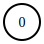

In [225]:
initial_state = f.add_state()
f.set_start(initial_state)
print(initial_state)
print_fst(f)

States are connected via arcs. In an FSA, an arc "consumes" a letter on the alphabet. If a word is in an FSA's language, then we spell out the word by "consuming" each letter in it as we traverse the arcs of the FSA. Let's illustrate this by adding an arc for 'c' going out of the initial state.

We define an arc using `pynini.Arc` which takes the arguments `(input_label, output_label, weight, next_state)`. Don't worry about input vs. output labels right now, we'll explain the purpose of those later. For now, know that for an FSA the input and output labels for any arc are always the same. Likewise, we're ignoring `weight` for now, and so we're setting it to `None`. Since we're drawing an arc to the second state, we set `second_state` as the value for `next_state`.

To add the arc to the graph, we use the `Fst.add_arc()` function which takes the arguments `(first_state, arc)`. Since we're drawing an arc from the initial state we pass `initial_state` to this function.

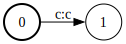

In [226]:
second_state = f.add_state()
first_letter = 'c'
first_letter_code = ord(first_letter)
nullweight = None
arc_to_second_state = pynini.Arc(first_letter_code, first_letter_code, nullweight, second_state)
f.add_arc(initial_state, arc_to_second_state)
print_fst(f)

Now let's make the rest of our word 'cat.'

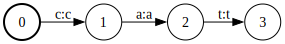

In [227]:
third_state = f.add_state()
second_letter = 'a'
second_letter_code = ord(second_letter)
arc_to_third_state = pynini.Arc(second_letter_code, second_letter_code, nullweight, third_state)
f.add_arc(second_state, arc_to_third_state)

fourth_state = f.add_state()
third_letter = 't'
third_letter_code = ord(third_letter)
arc_to_fourth_state = pynini.Arc(third_letter_code, third_letter_code, nullweight, fourth_state)
f.add_arc(third_state, arc_to_fourth_state)

print_fst(f)

And now we have an FSA describing the word "cat". Only one thing is missing, and that's to set a final state, that way the FSA knows that "cat" is a complete word on our language. We do this by simply calling `Fst.set_final()`.

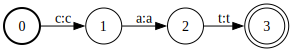

In [228]:
f.set_final(fourth_state)
print_fst(f)

To prove that our FSA recognizes the word "cat" we can call `Fst.string()`

In [229]:
f.string()

'cat'

Now let's expand our FSA to also recognize "cab". To save space and typing let's do this in a for loop, keeping track of our place in the graph using `curr_state` and `next_state`.

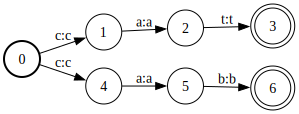

In [230]:
curr_state = initial_state
word = 'cab'
for letter in word:
    letter_code = ord(letter)
    next_state = f.add_state()
    arc_to_next_state = pynini.Arc(letter_code, letter_code, nullweight, next_state)
    f.add_arc(curr_state, arc_to_next_state)
    curr_state = next_state
f.set_final(curr_state)
print_fst(f)

Our graph here is a bit redundant. If "cat" and "cab" both share the prefix "ca", why does the graph split at the beginning? Shouldn't the graph only split where the words diverge, namely at t/b?

A lot of work has been done on optimizing and pruning FST graphs. While I won't go into any of that here, I do want to point out the function `pynini.optimize()` which will perform various functions to eliminate redundancies and improve performance on a given FST. Take a look at what our graph looks like pre- and post-optimization.

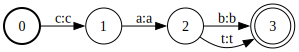

In [231]:
f_optimized = pynini.optimize(f)
print_fst(f_optimized)

Also notice that we can have two arcs going between two states. Because of this, "cat" and "car" don't need to end up in different *states* at all, as long as the arc leading into the final state can be either an "rb or a "t".

Let's imagine a different scenario. Let's edit the unoptimized FSA `f` to add 'cabs' to the language, so that we accept 'cab', 'cabs' and 'cat', but not 'cats'.

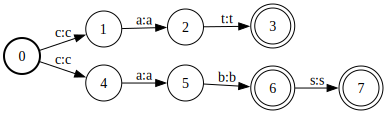

In [232]:
cars_state = f.add_state()
plural_suffix = 's'
plural_suffix_code = ord(plural_suffix)
arc_to_cars = pynini.Arc(plural_suffix_code, plural_suffix_code, nullweight, cars_state)
f.add_arc(curr_state, arc_to_cars)
f.set_final(cars_state)
print_fst(f)

**PAUSE:** What do you think this new graph will look like when optimized?  
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
(blank space to prevent the temptation to scroll down)
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

Now each path does need a diverging state, else there would be no way to prevent adding an "s" after "cat".

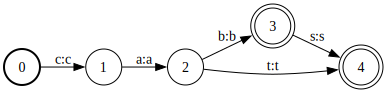

In [233]:
f_optimized = pynini.optimize(f)
print_fst(f_optimized)

**EXERCISE 1:** Create an FSA accepting the language {"student", "students", "teacher", "teachers", "person", "people"}. You should make "teachers/students" ideally by first building a complete path for "teacher/student" and then adding an arc to a new state that adds the "s" suffix. Bonus points if you can make "student" and "teacher" end at the same point so that only one path for plural "s" is needed, rather than one for each word. Also remember that a valid path on an FSA must terminate in a final state!

In [234]:
suffixable_words = ["student", "teacher"]
unsuffixable_words = ["person", "people"]

f = pynini.Fst()
f.set_input_symbols(ascii_table)
f.set_output_symbols(ascii_table)
initial_state = f.add_state()
f.set_start(initial_state)

curr_state = initial_state
for word in suffixable_words:
    for letter in word:
        next_state = f.add_state()
        # Your code here

for word in unsuffixable_words:
    for letter in word:
        next_state = f.add_state()
        # Your code here

print_fst(f)

## Section 2: FSTs
Now that we've covered FSAs (which are a special case of FST), let's cover FSTs more broadly.

Note the difference in name between Finite State *Acceptor* and Finite State *Transducer*. Where an FSA merely *accepts* a language, an FST *transduces* between two languages.

What does it mean to transduce between languages? Let's imagine two scenarios. In one, we transduce a set of singular nouns to their plural, and in another we transduce a set of words to their respective phonemes. We can represent these mathematically as mappings, i.e. {"student", "students", "teacher", "teachers", "person", "people"} or {"cat": "k ae t", "cab":  "k ae b"}. An FSA, then, can be thought of as vacuously "transducing" from one language to itself, i.e. {"cat": "cat", "cab": "cab"}.

Let's see this in action mapping "lock" and "box" to their phonemes. We'll make use of the *epsilon* symbol, represented in the `SymbolTable` we defined above as `<eps>`. This represents an empty label, and will allow us to have an input word with a different length than the output word. Epsilon is always indexed to 0 for a given FST in Pynini.

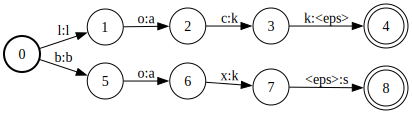

In [235]:
epsilon = '<eps>'
epsilon_code = 0
words_and_phonemes = [
    (['l', 'o', 'c', 'k'],      ['l', 'a', 'k', epsilon]),
    (['b', 'o', 'x', epsilon],  ['b', 'a', 'k', 's']),
]

word2phonemes = pynini.Fst()
word2phonemes.set_input_symbols(ascii_table)
word2phonemes.set_output_symbols(ascii_table)

initial_state = word2phonemes.add_state()
word2phonemes.set_start(initial_state)

for word, phones in words_and_phonemes:
    curr_state = initial_state
    for input_letter, output_letter in zip(word, phones):
        input_code = ord(input_letter) if input_letter!=epsilon else epsilon_code
        output_code = ord(output_letter) if output_letter!=epsilon else epsilon_code

        next_state = word2phonemes.add_state()
        next_arc = pynini.Arc(input_code, output_code, nullweight, next_state)
        word2phonemes.add_arc(curr_state, next_arc)
        curr_state = next_state
    word2phonemes.set_final(curr_state)
print_fst(word2phonemes)
    

Now we have a graph mapping words to phonemes, but how do we use it? We can make use of a versatile tool called **FST composition**. While a formal definition of FST composition can be somewhat difficult to parse for those less familiar with set theory, the intuitive explanation is much easier to grasp.

We've been talking about FSTs as a graph that models a language or a relation between two languages. In the latter case, we talk about an *input language* (words in the case above) and an *output language* (phonemes in the case above). This allows us to talk about the FST as a *function* that maps the input language to the output language.

Any mathematical function can be reduced to a mapping of inputs to outputs. For example, the function $f(x)=x^2$ maps a number $x$ to its square. Likewise, the function $h(x)=2x$ maps a number $x$ to the number that is twice its value. The composition of these functions, e.g. $f(h(x))$ outputs the square of twice of $x$, since $f(x)$ is applied to the output of $h(x)$, and vice versa with $h(f(x))$, which outputs twice the square of $x$.

We can represent the composition $f(h(x))$ as $h\circ{f}(x)$ and vice versa---notice the flip in order, this is because for the notation $f(h(x))$ we do the computation inwards-out: $h$ then $x$. For the notation $h\circ{f}$ we do the computation left-to-right, and so we still do the same order $h$ then $f$.
Let's extend this to FSTs. If we have one FST $A$ that maps $a\mapsto{b}$ and another FST $B$ that maps $b\mapsto{c}$, then the composition $A\circ{B}$ maps $a\mapsto{c}$.

Now for a simple example. Let's create an FSA for the word 'lock', and compose it with the graph we created above.

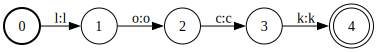

In [236]:
word_fsa = pynini.Fst()
word_fsa.set_input_symbols(ascii_table)
word_fsa.set_output_symbols(ascii_table)
initial_state=word_fsa.add_state()
word_fsa.set_start(initial_state)

curr_state = initial_state
word = 'lock'

for letter in word:
    next_state = word_fsa.add_state()
    letter_code = ord(letter)
    next_arc = pynini.Arc(letter_code, letter_code, nullweight, next_state)
    word_fsa.add_arc(curr_state, next_arc)
    curr_state = next_state
word_fsa.set_final(curr_state)
print_fst(word_fsa)

In Pynini FST composition can be done easily with the `@` symbol.

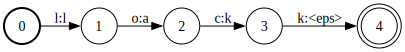

In [237]:
composed_fst=word_fsa@word2phonemes
print_fst(composed_fst)

Now we can get the phonemes for the word "lock" by calling `Fst.string()` on the composed graph.

In [238]:
word_fsa.string(), composed_fst.string()

('lock', 'lak')

What if instead we have a list of phonemes and we want to transduce them to the matching word? We can simply invert the `word2phonemes` graph and then compose it with an FSA with our respective phonemes.

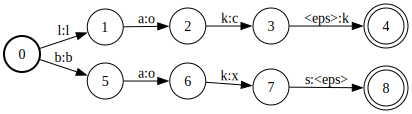

In [239]:
phonemes2words = pynini.invert(word2phonemes)
print_fst(phonemes2words)

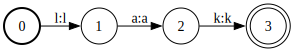

In [240]:
phonemes_fsa = pynini.Fst()
phonemes_fsa.set_input_symbols(ascii_table)
phonemes_fsa.set_output_symbols(ascii_table)
initial_state=phonemes_fsa.add_state()
phonemes_fsa.set_start(initial_state)

curr_state = initial_state
phonemes = 'lak'

for phoneme in phonemes:
    next_state = phonemes_fsa.add_state()
    letter_code = ord(phoneme)
    next_arc = pynini.Arc(letter_code, letter_code, nullweight, next_state)
    phonemes_fsa.add_arc(curr_state, next_arc)
    curr_state = next_state
phonemes_fsa.set_final(curr_state)
print_fst(phonemes_fsa)

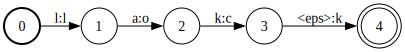

In [241]:
composed_fst = phonemes_fsa@phonemes2words
print_fst(composed_fst)

In [242]:
phonemes_fsa.string(), composed_fst.string()

('lak', 'lock')

While in this case it might seem like we got little juice out of a very effortful squeeze, the concept of FST composition will prove to be very versatile and useful for the remainder of this tutorial.

**EXERCISE 2:** Write a generic function `add_path` that adds a path to an FST mapping any input string to any output string. Recall from above that when we matched "lock" to [lak] and "box" to [baks] we manually padded the shorter sequence with an epsilon. In your function, you will need to handle epsilon insertion dynamically, as you don't know ahead of time which sequence is longer and by how much. The function should return `curr_state`, which will point to the last state in the path added.

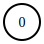

In [243]:
def add_path(f: pynini.Fst, curr_state: int, input_str: str, output_str: str):
    # pad input_str or output_str here

    for input_letter, output_letter in zip(input_str, output_str):
        ...
        # add arcs for path here

    return curr_state
    

f = pynini.Fst()
f.set_input_symbols(ascii_table)
f.set_output_symbols(ascii_table)
initial_state = f.add_state()
f.set_start(initial_state)


input_str = "elocution"
output_str = "ehlowkyushaxn" # linguists may find Arpabet strings unseemly. I can sympathize.

last_state = add_path(f, curr_state=initial_state, input_str=input_str, output_str=output_str)
print_fst(f)

**Exercise 3:** Using the `add_path` function you just wrote, create one FST that maps singular nouns to plural and another that maps words to phonemes. Then compose the two so that you have a graph mapping words to the phonemes of the plural form of the word.

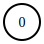

In [244]:
words_and_phonemes = [
    ("student", "stuwdixnt"),
    ("students", "stuwdixnts"),
    ("teacher", "tiychaxr"),
    ("teachers", "tiychaxrz"),
    ("person", "paxrsahn"),
    ("people", "piypaxl"),
]

word2phonemes = pynini.Fst()
word2phonemes.set_input_symbols(ascii_table)
word2phonemes.set_output_symbols(ascii_table)
initial_state =  word2phonemes.add_state()
word2phonemes.set_start(initial_state)

# build an FST mapping all words from the list above to their respective phonemes

print_fst(word2phonemes)

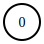

In [245]:
singulars_and_plurals = [
    ("student", "students"),
    ("teacher", "teachers"),
    ("person", "people"),
]

singular2plural = pynini.Fst()
singular2plural.set_input_symbols(ascii_table)
singular2plural.set_output_symbols(ascii_table)
initial_state =  singular2plural.add_state()
singular2plural.set_start(initial_state)

# build an FST mapping all words from the list above to their respective plural forms
# your code here

print_fst(singular2plural)

In [246]:
# now, compose the previous to graphs so that it maps a word to the phonemes of its plural
composed_fst = pynini.Fst() # delete and replace with your code
print_fst(composed_fst)

**EXERCISE 4:** Using `word2phonemes` and `singular2plural` from Exercise 3, create an FST that maps a sequence of *phonemes* to the *plural form* of the corresponding word. One of the graphs will need to be inverted. Also think about what order the FSTs should be composed in.

In [247]:
reversed_fst = pynini.invert(pynini.Fst()) # delete and replace with your own code
composed_fst = pynini.Fst()
print_fst(composed_fst)

## Section 3: Weighted FSTs
Up until now we've been ignoring the `weight` parameter when building FSTs. Now let's explain what this weight does.

A *weight* on an arc can be thought of as some cost associated with it. If we think of graphs as a type of map, where arcs are roads and states are geographic destinations, then an arc's weight can be thought of as the spacial distance of a road connecting two destinations. Generally, if you're trying to get from point $A$ to point $B$, you're probably going to want to take the shortest route possible. That means that you'll try to minimize the total distance of the roads you travel, or in FST-land, you'll try to minimize the weight of the arcs you traverse. From now on, I'll use Weighted Finite State Transducer (WFST) to refer to an FST with weights/costs and FST as an umbrella term for FSTs with and without weight/cost.

Terminology note: though Pynini (and most of the FST literature) uses the term `weight` in its API, I will prefer the term 'cost' where possible to avoid confusion with a weight in a neural network, since a neural network larger weight indicates *higher* probability of a given connection, whereas a larger WFST weight/cost indicates *lower* probability. The term 'WFST' itself is pretty standardly entrenched, though, so I won't use a term like "Cost Finite State Transducer."

In terms of modeling language, we can think of cost as the inverse probability or frequency of a given mapping. Take the English verb 'dive' for example, for which 'dived' and 'dove' are considered proper forms of the past tense. Let's assume for the sake of this exercise that 'dived' is used more often than 'dove', which we can represent by giving 'dived' a smaller cost. Notice that the cost is indicate on the graph following a forward slash after the input:output symbols. In this graph, the cost is only specified at the junction where "dived" and "dove" diverge, as only one difference in cost is needed in order for either path to be more or less costly overall.

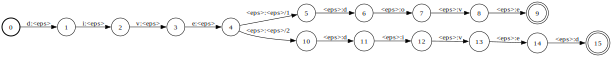

In [248]:
dive_past_tense = pynini.Fst()
dive_past_tense.set_input_symbols(ascii_table)
dive_past_tense.set_output_symbols(ascii_table)
initial_state = dive_past_tense.add_state()
dive_past_tense.set_start(initial_state)


present_form = "dive"
dove_cost = 1
dived_cost = 2
past_forms = [("dove", dove_cost), ("dived", dived_cost)]

# first create path accepting "dive" as input
curr_state = initial_state
for letter in present_form:
    letter_code = ord(letter)
    next_state = dive_past_tense.add_state()
    next_arc = pynini.Arc(letter_code, epsilon_code, nullweight, next_state)
    dive_past_tense.add_arc(curr_state, next_arc)
    curr_state = next_state


# now continue the path with either "dived" or "dove" as output
# with the appropriate cost for each form
present_form_end_state = curr_state
for past_form, cost in past_forms:
    curr_state = dive_past_tense.add_state()
    arc_to_past_form = pynini.Arc(epsilon_code, epsilon_code, cost, curr_state)
    dive_past_tense.add_arc(present_form_end_state, arc_to_past_form)

    for letter in past_form:
        next_state = dive_past_tense.add_state()
        letter_code = ord(letter)
        next_arc = pynini.Arc(epsilon_code, letter_code, nullweight, next_state)
        dive_past_tense.add_arc(curr_state, next_arc)
        curr_state = next_state
    dive_past_tense.set_final(curr_state)

print_fst(dive_past_tense)

We can then use the `pynini.shortestpath()` function to find the most likely form on the given graph.

In [249]:
dive_shortestpath = pynini.shortestpath(dive_past_tense)
print(dive_shortestpath.string())
print_fst(dive_shortestpath)

dove


**EXERCISE 5:** Create a WFST mapping "the" to ARPABET [dhiy] (IPA [ði]) with a cost of 2 and [dhax] (IPA [ðə]) with a cost of 1. Then print the shortest path. Which pronunciation is more probable given this graph?

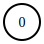

In [250]:
orthography = "the"
pronunciations_and_costs = [("dhiy", 2), ("dhax", 1)]

the_pronunciation = pynini.Fst()
the_pronunciation.set_input_symbols(ascii_table)
the_pronunciation.set_output_symbols(ascii_table)

initial_state = the_pronunciation.add_state()
the_pronunciation.set_start(initial_state)

# your code here

print_fst(the_pronunciation)

In [251]:
the_shortestpath = pynini.shortestpath(the_pronunciation)
# print(the_shortestpath.string()) # commented to prevent an error: uncomment when you've completed the part above
print_fst(the_shortestpath)

## Section 4: Efficient FST creation with Pynini
So far writing FSTs has been a bit tedious, since we need to add each state and arc separately. Now that we've wrapped our head around the inner workings of FSTs, though, we can cheat a bit and use pre-built methods in Pynini that will make our lives much easier.

For example, we can create a simple FSA using `pynini.accep` and a transducer with `pynini.cross`.

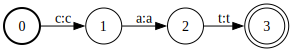

In [252]:
cat_fsa = pynini.accep("cat")

cat_fsa.set_input_symbols(ascii_table)
cat_fsa.set_output_symbols(ascii_table)

print_fst(cat_fsa)

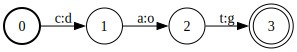

In [253]:
cat2dog_fst = pynini.cross("cat", "dog")

cat2dog_fst.set_input_symbols(ascii_table)
cat2dog_fst.set_output_symbols(ascii_table)

print_fst(cat2dog_fst)

We can do other operations like concatenate or take a union of several FSTs.

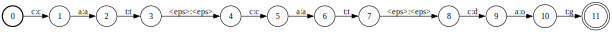

In [254]:
print_fst(cat_fsa+cat_fsa+cat2dog_fst)

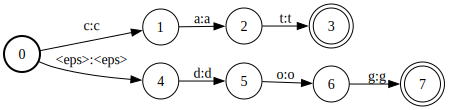

In [255]:
dog_fsa = pynini.accep("dog")
dog_fsa.set_input_symbols(ascii_table)
dog_fsa.set_output_symbols(ascii_table)

cat_or_dog_fsa = cat_fsa|dog_fsa
print_fst(cat_or_dog_fsa)

We can also take a "closure" over an FST, which is like the star operator in regular expressions: it produces an FST corresponding to zero or arbitrarily many of the original FST.

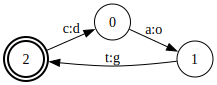

In [256]:
cat2dog_closure = pynini.closure(cat2dog_fst).optimize()
print_fst(cat2dog_closure)

Since closure allows for zero repetitions, `(""@cat2dog_closure).string()` will return an empty string.

In [257]:
("catcatcatcat"@cat2dog_closure).string()

'dogdogdogdog'

Similar to `pynini.closure()` we can use `Fst.plus` to allow 1 or more (but not zero) repetitions of the FST.

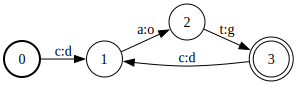

In [258]:
cat2dog_plus = cat2dog_fst.plus.optimize()
print_fst(cat2dog_plus)

Since plus allows for one or more repetitions, `(""@cat2dog_plus).string()` will raise an FST compilation error.

In [259]:
("catcatcat"@cat2dog_plus).string()

'dogdogdog'

We can even transduce between two FSTs.

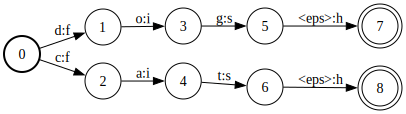

In [260]:
fish_fsa = pynini.accep("fish")
fish_fsa.set_input_symbols(ascii_table)
fish_fsa.set_output_symbols(ascii_table)

cat_or_dog2fish_fst = pynini.cross(cat_or_dog_fsa, fish_fsa)
print_fst(cat_or_dog2fish_fst)

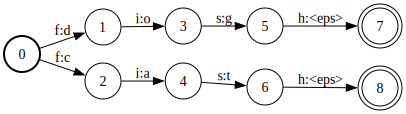

In [261]:
fish2cat_or_dog_fst = pynini.cross(fish_fsa, cat_or_dog_fsa)
print_fst(fish2cat_or_dog_fst)

Remember the FSTs we made for Exercise 3? Each can be made in a single line (not counting the boilerplate for setting symbol tables and optimizing) using `pynini.string_map()`, which takes a list of tuples as input and returns an FST mapping the first element of each tuple to the second.

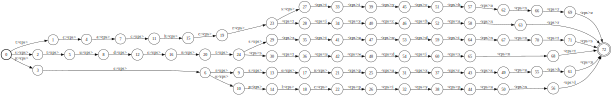

In [262]:
word2phonemes = pynini.string_map(words_and_phonemes)
word2phonemes.set_input_symbols(ascii_table)
word2phonemes.set_output_symbols(ascii_table)
word2phonemes.optimize()
print_fst(word2phonemes)

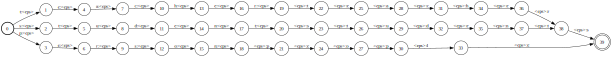

In [263]:
singular2plural = pynini.string_map(singulars_and_plurals)
singular2plural.set_input_symbols(ascii_table)
singular2plural.set_output_symbols(ascii_table)
singular2plural.optimize()
print_fst(singular2plural)

Pynini also autocasts a string to an FSA over the same string, which can make FST composition much more concise.

In [264]:
("student"@singular2plural).string(), ("student"@word2phonemes).string()

('students', 'stuwdixnt')

Just like we added costs to arcs before, now we can add a cost for an entire FST. Let's repeat the dive/dived/dove example from before.

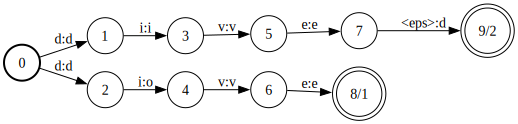

In [265]:
dive_fsa = pynini.accep("dive")
dove_fsa = pynini.accep("dove", weight=dove_cost)
dived_fsa = pynini.accep("dived", weight=dived_cost)

past_forms_fsa = pynini.union(dove_fsa, dived_fsa)
dive_past_tense = pynini.cross(dive_fsa, past_forms_fsa)
dive_past_tense.set_input_symbols(ascii_table)
dive_past_tense.set_output_symbols(ascii_table)

print_fst(dive_past_tense)

dove


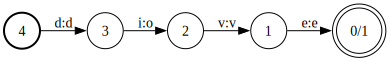

In [266]:
dive_shortestpath = pynini.shortestpath(dive_past_tense)
print(dive_shortestpath.string())
print_fst(dive_shortestpath)

**EXERCISE 6:** Repeat Exercise 5, this time using convenient Pynini functions rather than building the entire WFST from scratch.

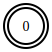

In [267]:
the_pronunciation = pynini.cross('', '')
the_pronunciation.set_input_symbols(ascii_table)
the_pronunciation.set_output_symbols(ascii_table)

print_fst(the_pronunciation)

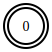

In [268]:
the_shortestpath = pynini.shortestpath(the_pronunciation)
print(the_shortestpath.string())
print_fst(the_shortestpath)

Now let's expand our example. We first need to define a dictionary that stores words and their associated phonemes.

In [269]:
lexicon = {
    "she": "sh iy",
    "sells": "s eh l z",
    "seashells": "s iy sh eh l z",
    "by": "b ay",
    "the": "dh ax",
    "seashore": "s iy sh aw r",
}

words = set()
phones = set()

for word, phone_list in lexicon.items():
    words.add(word)
    phones.update(phone_list.split())
words, phones

({'by', 'seashells', 'seashore', 'sells', 'she', 'the'},
 {'aw', 'ax', 'ay', 'b', 'dh', 'eh', 'iy', 'l', 'r', 's', 'sh', 'z'})

Whereas before we were using one arc per letter and used the `ascii_table` for rendering, this time we'll define a specific `SymbolTable` where each word and phone in our lexicon has a unique symbol, which will greatly help readability when rendering FSTs.

To avoid having to constantly set the symbol table each time we create an FST, we write the `fsa` function which returns an FSA with the symbol table already set. We can then use this as input to any other Pynini FST function and the symbol table will persist. We likewise define the `fst_string()` function since `Fst.string()` requires passing the symbol table even if it has already been set for the FST object.

In [270]:
symbols = pynini.SymbolTable()
symbols.add_symbol('<eps>')

for word in words:
    symbols.add_symbol(word)

for phone in phones:
    symbols.add_symbol(phone)

def set_symbols(f: pynini.Fst) -> pynini.Fst:
    """
    Set input and output symbols for a FST `f` to the
    user-defined symbol table.
    """
    f=f.set_input_symbols(symbols)
    f=f.set_output_symbols(symbols)
    return f

def fsa(acceptor_str: Union[str, List[str]], weight: Optional[pynini.WeightLike]=None) -> pynini.Fst:
    """
    Create a Finite State Acceptor of the given string using
    the symbols table.
    """
    if type(acceptor_str) is list:
        acceptor_str = ' '.join(acceptor_str)
    f=pynini.accep(acceptor_str, weight=weight, token_type=symbols)
    f=set_symbols(f)
    f=f.optimize()
    return f

def fst_string(f):
    return f.string(token_type=symbols)

Let's create an FST mapping words to phonemes.

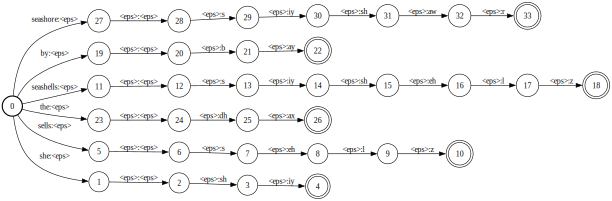

In [271]:
word2phonemes=pynini.string_map(lexicon.items(), input_token_type=symbols, output_token_type=symbols)
set_symbols(word2phonemes)
print_fst(word2phonemes)

Notice how the FST changes shape and loses the vacuous `<eps>:<eps>` arcs when we optimize it.

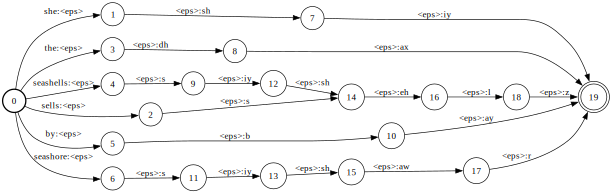

In [272]:
print_fst(word2phonemes.optimize())

Now let's make an inverted FST mapping words to phonemes.

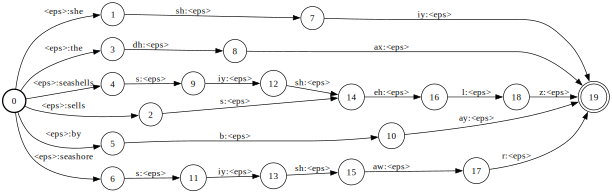

In [273]:
phonemes2word = pynini.invert(word2phonemes)
print_fst(phonemes2word)

We can compose an FST of a phoneme sequence with `phonemes2word` to get the corresponding word. Note that we need to use the `fsa` method we defined earlier since if we let Pynini autocast a string it won't set the symbol table.

she


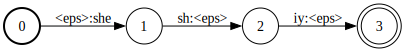

In [274]:
f=fsa("sh iy")@phonemes2word
print(fst_string(f))
print_fst(f)

(Just to show that if we don't wrap the string with the `fsa` function we don't get any output due to the symbol table mismatch)

In [275]:
print_fst("sh iy"@phonemes2word)

Or vice versa to get a list of phonemes.

s iy sh eh l z


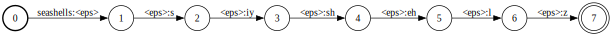

In [276]:
f=fsa("seashells")@word2phonemes
print(fst_string(f))
print_fst(f)

## Section 5: Applying FSTs to speech
Now let's think about how this will be applied in the ASR case. For ASR, we won't be mapping a simple sequence of phonemes to words. Instead, our input is *variable in length* and it is a *probability distribution over phonemes*.

Let's tackle the first part, variability in length. In speech, we don't know ahead of time how long each phoneme will be (and in many cases, it may be difficult or even impossible to clearly delimit the boundaries of one phoneme from the next). Let's make one simplifying assumption: if we define a certain minimum time span, e.g. 10ms, we can expect that any given phoneme will correspond to one or more consecutive units of that time span. So if a phoneme /a/ lasts for 97ms, we will model it as a sequence of nine 10ms intervals.

What does this mean for our FSTs? Now if we have an FST converting a pronunciation to the respective word, it needs to be able to handle *repeating instances of each phoneme*. For example [sh iy], [sh sh iy iy] and [sh sh sh iy iy iy iy iy] all need to map to "she". We can do this by using the `Fst.plus` operator provided by Pynini we saw before.

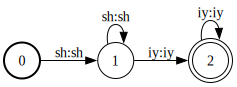

In [277]:
she_pronunciation_fsa = fsa("sh").plus + fsa("iy").plus
she_pronunciation_fsa.optimize()
print_fst(she_pronunciation_fsa)

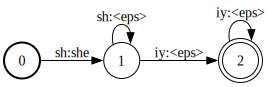

In [278]:
she_pronunciation_fst = pynini.cross(she_pronunciation_fsa, fsa("she"))
print_fst(she_pronunciation_fst)

Try running the following cell while varying the number of [sh]'s and [iy]'s, you should always get the same output.

she


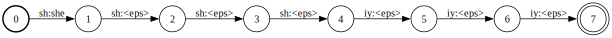

In [279]:
composed_she_pronunciation = fsa("sh sh sh sh iy iy iy")@she_pronunciation_fst
print(fst_string(composed_she_pronunciation))
print_fst(composed_she_pronunciation)

Let's encapsulate the logic for making an FSA allowing for multiple repetitions of each phoneme.

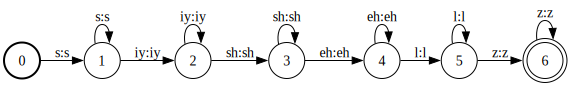

In [280]:
def phoneme_fsa(phoneme_str):
    phoneme_fsa = fsa("")
    for phoneme in phoneme_str.split():
        phoneme_fsa += fsa(phoneme).plus
    phoneme_fsa.optimize()
    return phoneme_fsa
seashells_fsa = phoneme_fsa("s iy sh eh l z")
print_fst(seashells_fsa)

Let's now recreate our FST mapping phonemes to words using this logic. We can do this by making several FSTs with `pynini.cross()` that each map one phoneme sequence to a particular word, and then take the union over these FSTs.

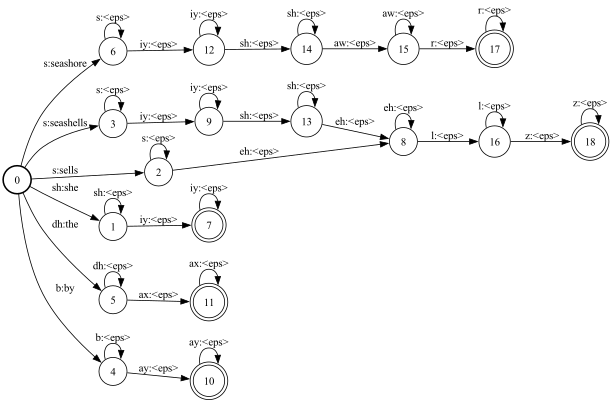

In [281]:
phone2word_fsts = [
    pynini.cross(phoneme_fsa(value), fsa(key))
    for key, value in lexicon.items()
]

phonemes_plus2words = pynini.union(*phone2word_fsts)
phonemes_plus2words.optimize()
phonemes_plus2words

Try changing the phonemes in the following cell to output different words on our lexicon!

In [282]:
composed_pronunciation = fsa("s s iy iy iy sh eh eh l z z")@phonemes_plus2words
print(fst_string(composed_pronunciation))
print_fst(composed_pronunciation)

seashells


Our FST `phonemes_plus2words` allows us to map a pronunciation to a *single word* on our lexicon. What if we want to map a sequence of words? We can do this simply by taking a closure over `phoneme_plus2words`.

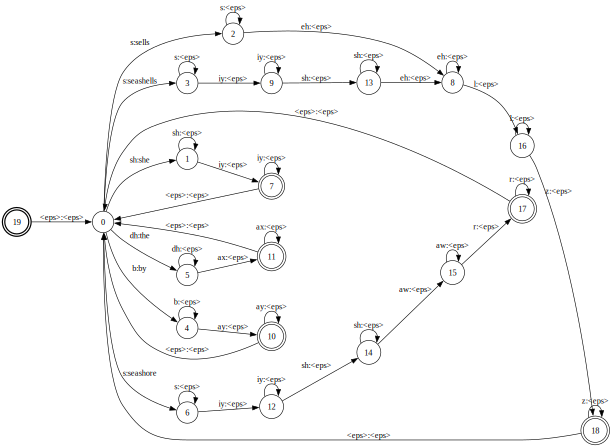

In [283]:
phonemes2words_closure = pynini.closure(phonemes_plus2words)
print_fst(phonemes2words_closure)

In [284]:
composed_pronunciation_sequence = fsa("sh sh iy iy s s eh l l z s iy iy sh sh eh l l z")@phonemes2words_closure
print(fst_string(composed_pronunciation_sequence))
print_fst(composed_pronunciation_sequence)

she sells seashells


**EXERCISE 7:** Create an FST that models the pronunciation for any number of repetitions of "she sells" and rejects any other words. So it should map:
- sh iy s eh l z > "she sells"
- sh sh iy iy s s eh l l z z > "she sells"
- sh iy iy s eh l z sh iy iy s s eh l z > "she sells she sells"  

And so on. But it should *not* accept:
- sh iy sh iy s eh l l z > *she she sells


Hint: first make an FST accepting a single instance of "she sells" then make a closure.

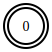

In [285]:
shesells_fst = pynini.cross(fsa(''), fsa(''))
shesells_closure_fst = pynini.closure(fsa(''))

shesells_closure_fst.optimize()
print_fst(shesells_closure_fst)

Now let's address the second part of using FSTs with speech mentioned above, namely that we will input *probability distributions of phonemes* rather than discrete phonemes. Let's demonstrate this by creating an FST that can map the phonemes for [dh dh ax ax] or [sh sh iy iy], but has higher probability for [sh sh iy iy].

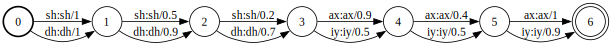

In [286]:
phoneme_probabilities = (fsa("sh", weight=1.0) | fsa("dh", weight=1.0)) +\
    (fsa("sh", weight=0.5) | fsa("dh", weight=0.9)) +\
    (fsa("sh", weight=0.2) | fsa("dh", weight=0.7)) +\
    (fsa("iy", weight=0.5) | fsa("ax", weight=0.9)) +\
    (fsa("iy", weight=0.5) | fsa("ax", weight=0.4)) +\
    (fsa("iy", weight=0.9) | fsa("ax", weight=1.0))
phoneme_probabilities.optimize()
print_fst(phoneme_probabilities)

When we compose this with our FST mapping phonemes to words, we get a probability distribution over the words "the" and "she."

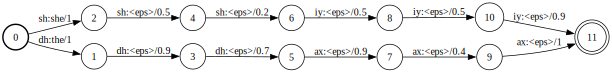

In [287]:
phonem_probs_composed = phoneme_probabilities@phonemes2words_closure
phonem_probs_composed.optimize()
print_fst(phonem_probs_composed)

Let's then take the shortest path to see that "she" is the most likely word for these phoneme probabilities.

she


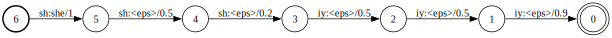

In [288]:
phoneme_probs_shortestpath = pynini.shortestpath(phonem_probs_composed)
print(fst_string(phoneme_probs_shortestpath))
print_fst(phoneme_probs_shortestpath)

Let's make our lives a bit easier and encapsulate the logic for making a phoneme probability FST. We'll do this by first making a matrix where each row is a timestep and each column is a phoneme (with the column indices determined by the `phonelist` defined below), and then build an FST based on the costs defined in the matrix.

In [289]:
phonelist = list(phones)
phonelist

['s', 'sh', 'eh', 'z', 'ax', 'iy', 'l', 'r', 'ay', 'aw', 'dh', 'b']

I've left some code here that will make "seashore" be the most likely word output and "by the seashore" the second most likely. I've also left commented-out code that will let you set random costs, feel free to play around and see what words you get.

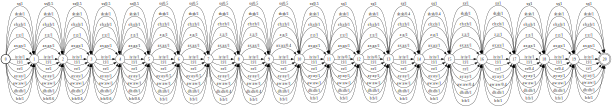

In [290]:
num_timesteps = 20

# UNCOMMENT THIS LINE TO USE RANDOM PROBABILITIES
# cost_matrix = np.random.random((num_timesteps, len(phonelist)))

# UNCOMMENT THIS BLOCK TO SET "seashore" as most probable and "by the seashore" as second mostp probable
cost_matrix = np.ones((num_timesteps, len(phonelist)))

cost_matrix[1:11, phonelist.index("s" )] = 0.5
cost_matrix[11:13, phonelist.index("iy")] = 0.5
cost_matrix[13:15, phonelist.index("sh")] = 0.4
cost_matrix[15:17, phonelist.index("aw")] = 0.4
cost_matrix[17:19, phonelist.index("r")] = 0.4


cost_matrix[1:5, phonelist.index("b" )] = 0.6
cost_matrix[5:7, phonelist.index("ay")] = 0.5
cost_matrix[7:9, phonelist.index("dh")] = 0.4
cost_matrix[9:10, phonelist.index("ax")] = 0.4
# END BLOCK

def make_phone_probabilities(cost_matrix: np.ndarray) -> pynini.Fst:
    phoneme_probs = fsa('')
    for timestep_vector in cost_matrix:
        timestep_probs = None
        for i, phoneme in enumerate(phonelist):
            phoneme_cost = timestep_vector[i]
            phoneme_prob_fsa = fsa(phoneme, weight=phoneme_cost)
            if timestep_probs is None:
                timestep_probs = phoneme_prob_fsa
            else:
                timestep_probs = timestep_probs | phoneme_prob_fsa
        phoneme_probs = phoneme_probs + timestep_probs
    return phoneme_probs.optimize()
phoneme_probs = make_phone_probabilities(cost_matrix)
print_fst(phoneme_probs)

In [291]:
phoneme_probs_composed = (phoneme_probs@phonemes2words_closure).optimize()
probs_shortestpath = pynini.shortestpath(phoneme_probs_composed)
print(fst_string(probs_shortestpath))
print_fst(probs_shortestpath)

seashore


In [292]:
from pynini.lib.rewrite import lattice_to_nshortest, lattice_to_strings
nshortest = lattice_to_nshortest(phoneme_probs_composed.project('output'), nshortest=2)
lattice_to_strings(nshortest, token_type=symbols)

['seashore', 'by the seashore']

**EXERCISE 8:** Write a phoneme cost matrix that gives the phrase "she sells seashells by the seashore" the highest probability when composed with `phonemes2words_closure`. Copy and paste is your friend here.

In [293]:
num_timesteps = 30
tonguetwister_matrix = np.ones((num_timesteps, len(phonelist)))
tonguetwister_matrix[0, phonelist.index('sh')] = 0.5
# your code here

tonguetwister_probs = make_phone_probabilities(tonguetwister_matrix)
tonguetwister_composed = (tonguetwister_probs@phonemes2words_closure).optimize()
tonguetwister_shortestpath = pynini.shortestpath(tonguetwister_composed)
print(fst_string(tonguetwister_shortestpath))
print_fst(tonguetwister_shortestpath)

she sells
